In [1]:
using Flux
using Flux.Tracker

f(x) = 3x^2 + 2x + 1
df(x) = Tracker.gradient(f, x; nest = true)[1]
df(3)

20.0 (tracked)

In [2]:
d2f(x) = Tracker.gradient(df, x; nest = true)[1]
d2f(3)

6.0 (tracked)

In [3]:
f(W, b, x) = W*x + b
Tracker.gradient(f, 2, 3, 4)

(4.0 (tracked), 1.0 (tracked), 2.0 (tracked))

In [4]:
W = param(2) # 2.0 (tracked)
b = param(3) # 3.0 (tracked)

f(x) = W * x + b

grads = Tracker.gradient(() -> f(4), params(W, b))

Grads(...)


In [5]:
(grads[W] , grads[b]) 

(4.0, 1.0)

---

In [6]:
W = rand(2, 5)
b = rand(2)

predict(x) = W*x .+ b

function loss(x, y)
  ŷ = predict(x)
  sum((y .- ŷ).^2)
end

x, y = rand(5), rand(2) # Dummy data
loss(x, y) # ~ 3

0.19977367493419768

In [7]:
W = param(W)
b = param(b)

gs = Tracker.gradient(() -> loss(x, y), params(W, b))

Grads(...)


In [8]:
gs[W]

Tracked 2×5 Array{Float64,2}:
 -0.0756615  -0.0282604  -0.245308  -0.0556396  -0.0927113
  0.0701236   0.0261919   0.227353   0.0515672   0.0859255

In [9]:
gs[b]

Tracked 2-element Array{Float64,1}:
 -0.6556360697646515
  0.6076479603852478

In [10]:
using Flux.Tracker: update!

D = gs[W]
update!(W, -0.1D)


Tracked 2×5 Array{Float64,2}:
 0.46683  0.0810045  0.829748  0.303616   0.778198
 0.25735  0.821648   0.905199  0.0288757  0.868002

In [11]:
loss(x, y) 

0.1854668672151869 (tracked)

---

In [18]:
using Flux, Flux.Data.MNIST, Statistics
using Flux: onehotbatch, onecold, crossentropy, throttle
using Base.Iterators: repeated

In [19]:
# Classify MNIST digits with a simple multi-layer-perceptron

imgs = MNIST.images()

# Stack images into one large batch
X = hcat(float.(reshape.(imgs, :))...)

784×60000 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  

In [20]:
labels = MNIST.labels()

# One-hot-encode the labels
Y = onehotbatch(labels, 0:9)

10×60000 Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}:
 false   true  false  false  false  …  false  false  false  false  false
 false  false  false   true  false     false  false  false  false  false
 false  false  false  false  false     false  false  false  false  false
 false  false  false  false  false     false   true  false  false  false
 false  false   true  false  false     false  false  false  false  false
  true  false  false  false  false  …  false  false   true  false  false
 false  false  false  false  false     false  false  false   true  false
 false  false  false  false  false     false  false  false  false  false
 false  false  false  false  false      true  false  false  false   true
 false  false  false  false   true     false  false  false  false  false

In [21]:
m = Chain(
  Dense(28^2, 32, relu),
  Dense(32, 10),
  softmax)

Chain(Dense(784, 32, NNlib.relu), Dense(32, 10), NNlib.softmax)

In [22]:
loss(x, y) = crossentropy(m(x), y)
accuracy(x, y) = mean(onecold(m(x)) .== onecold(y))

accuracy (generic function with 1 method)

In [23]:
dataset = repeated((X, Y), 200)
evalcb = () -> @show(loss(X, Y))
opt = ADAM()

ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}())

In [24]:
Flux.train!(loss, params(m), dataset, opt, cb = throttle(evalcb, 10))
accuracy(X, Y)

loss(X, Y) = 2.3206537f0 (tracked)
loss(X, Y) = 1.5341301f0 (tracked)
loss(X, Y) = 0.9846691f0 (tracked)
loss(X, Y) = 0.6895473f0 (tracked)
loss(X, Y) = 0.5434194f0 (tracked)
loss(X, Y) = 0.46452743f0 (tracked)
loss(X, Y) = 0.4157685f0 (tracked)
loss(X, Y) = 0.38233992f0 (tracked)
loss(X, Y) = 0.35742676f0 (tracked)
loss(X, Y) = 0.33777905f0 (tracked)
loss(X, Y) = 0.32168952f0 (tracked)
loss(X, Y) = 0.30813506f0 (tracked)
loss(X, Y) = 0.2964321f0 (tracked)
loss(X, Y) = 0.28611913f0 (tracked)
loss(X, Y) = 0.27689523f0 (tracked)


0.92355

In [25]:
# Test set accuracy
tX = hcat(float.(reshape.(MNIST.images(:test), :))...) |> gpu
tY = onehotbatch(MNIST.labels(:test), 0:9) |> gpu

accuracy(tX, tY)

0.9235

---

In [1]:
using Metalhead
using Metalhead: classify
using Images

┌ Info: Recompiling stale cache file /Users/malcolm/.julia/compiled/v1.0/Metalhead/OYscp.ji for Metalhead [dbeba491-748d-5e0e-a39e-b530a07fa0cc]
└ @ Base loading.jl:1190


In [4]:
# Switch to dataset images and classify the known (1000) images
cd(homedir()*"/PacktPub/Datasets/Images")
vgg = VGG19()

VGG19()

In [5]:
img01 = load("elephant.jpg")
classify(vgg, img01)

┌ Warning: `argmax(...)` is deprecated, use `onecold(...)` instead.
│   caller = classify(::VGG19, ::Array{RGB4{Normed{UInt8,8}},2}) at utils.jl:98
└ @ Metalhead /Users/malcolm/.julia/packages/Metalhead/fYeSU/src/utils.jl:98


"African elephant, Loxodonta africana"

In [6]:
using Unicode

img02 = load("harry.jpg")
animal = uppercase(classify(vgg, img02))
println("Meow, I am a $animal perhaps ???'")

Meow, I am a MINK perhaps ???'


In [7]:
animal_types = Metalhead.labels(vgg)
animal_types[1:5]

5-element Array{String,1}:
 "tench, Tinca tinca"                                                                 
 "goldfish, Carassius auratus"                                                        
 "great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias"
 "tiger shark, Galeocerdo cuvieri"                                                    
 "hammerhead, hammerhead shark"                                                       

In [8]:
# How sure are we?
#
probs = Metalhead.forward(vgg, img02)
sort(probs)[996:1000]

5-element Array{Float32,1}:
 0.00013183923
 0.00014438889
 0.0025139963 
 0.012086336  
 0.98500556   

In [33]:
perm = sortperm(probs)
animal_types[perm[1000]]

"mink"

In [34]:
animal_types[perm[999]]   # <= This is a breed of DOG. sorry Harry.

"schipperke"

In [35]:
animal_types[287:288]    # If not a cat -- why not one of these ?

2-element Array{String,1}:
 "cougar, puma, catamount, mountain lion, painter, panther, Felis concolor"
 "lynx, catamount"                                                         

---

In [2]:
pwd(); include("KnetJL/mnist-mlp/mlp.jl")

Main.MLP

In [3]:
MLP.main("--epochs 15")

mlp.jl (c) Deniz Yuret, 2016. Multi-layer perceptron model on the MNIST handwritten digit recognition problem from http://yann.lecun.com/exdb/mnist.
opts=(:batchsize, 100)(:fast, false)(:atype, "Array{Float32}")(:epochs, 15)(:gcheck, 0)(:winit, 0.1)(:lr, 0.5)(:hidden, Int64[])(:seed, -1)


┌ Info: Loading MNIST...
└ @ Main.MLP /Users/malcolm/.julia/packages/Knet/05UDD/data/mnist.jl:33


(:epoch, 0, :trn, 0.08636666666666666, :tst, 0.0875)
(:epoch, 1, :trn, 0.8992666666666667, :tst, 0.9025)
(:epoch, 2, :trn, 0.9079333333333334, :tst, 0.9101)
(:epoch, 3, :trn, 0.9113333333333333, :tst, 0.9116)
(:epoch, 4, :trn, 0.91355, :tst, 0.9128)
(:epoch, 5, :trn, 0.9150333333333334, :tst, 0.9137)
(:epoch, 6, :trn, 0.9167333333333333, :tst, 0.9145)
(:epoch, 7, :trn, 0.9177666666666666, :tst, 0.9144)
(:epoch, 8, :trn, 0.9184666666666667, :tst, 0.9143)
(:epoch, 9, :trn, 0.91915, :tst, 0.9152)
(:epoch, 10, :trn, 0.9195833333333333, :tst, 0.9155)
(:epoch, 11, :trn, 0.9202333333333333, :tst, 0.9159)
(:epoch, 12, :trn, 0.9204833333333333, :tst, 0.9161)
(:epoch, 13, :trn, 0.92085, :tst, 0.9161)
(:epoch, 14, :trn, 0.9211833333333334, :tst, 0.9162)
(:epoch, 15, :trn, 0.9216, :tst, 0.9166)
 13.801630 seconds (11.93 M allocations: 6.979 GiB, 6.39% gc time)


2-element Array{Any,1}:
 Float32[-0.145344 -0.0199002 … 0.110425 -0.0266048; -0.0876187 0.0865226 … 0.025035 0.0782428; … ; 0.100083 -0.0364283 … 0.0562371 -0.0669327; -0.0611903 -0.0816114 … 0.0908086 0.0837733]
 Float32[0.803058; 0.275694; … ; -0.503407; -1.09]                                                                                                                                          

---

In [66]:
using Knet, Images
cd(Knet.dir("examples"))
pwd()

"/Users/malcolm/.julia/packages/Knet/05UDD/examples"

In [68]:
include("mnist-mlp/mlp.jl")
MLP.main("--help")

usage: <PROGRAM> [--seed SEED] [--batchsize BATCHSIZE]
                 [--epochs EPOCHS] [--hidden [HIDDEN...]] [--lr LR]
                 [--winit WINIT] [--fast] [--atype ATYPE]
                 [--gcheck GCHECK]

mlp.jl (c) Deniz Yuret, 2016. Multi-layer perceptron model on the
MNIST handwritten digit recognition problem from
http://yann.lecun.com/exdb/mnist.



optional arguments:
  --seed SEED           random number seed: use a nonnegative int for
                        repeatable results (type: Int64, default: -1)
  --batchsize BATCHSIZE
                        minibatch size (type: Int64, default: 100)
  --epochs EPOCHS       number of epochs for training (type: Int64,
                        default: 10)
  --hidden [HIDDEN...]  sizes of hidden layers, e.g. --hidden 128 64
                        for a net with two hidden layers (type: Int64)
  --lr LR               learning rate (type: Float64, default: 0.5)
  --winit WINIT         w initialized with winit*randn() (type:
                        Float64, default: 0.1)
  --fast                skip loss printing for faster run
  --atype ATYPE         array type: Array for cpu, KnetArray for gpu
                        (default: "Array{Float32}")
  --gcheck GCHECK       check N random gradients per parameter (type:
                        Int64, default: 0)



In [14]:

MLP.main("--epochs 15")

mlp.jl (c) Deniz Yuret, 2016. Multi-layer perceptron model on the MNIST handwritten digit recognition problem from http://yann.lecun.com/exdb/mnist.
opts=(

:batchsize, 100)(:fast, false)(:atype, "Array{Float32}")(:epochs, 15)(:gcheck, 0)(:winit, 0.1)(:lr, 0.5)(:hidden, Int64[])(:seed, -1)


┌ Info: Loading MNIST...
└ @ Main.MLP /Users/malcolm/.julia/packages/Knet/05UDD/data/mnist.jl:33


(:epoch, 0, :trn, 0.10793333333333334, :tst, 0.1106)
(:epoch, 1, :trn, 0.9002333333333333, :tst, 0.9033)
(:epoch, 2, :trn, 0.9082, :tst, 0.9083)
(:epoch, 3, :trn, 0.91145, :tst, 0.9112)
(:epoch, 4, :trn, 0.9138833333333334, :tst, 0.9119)
(:epoch, 5, :trn, 0.9153333333333333, :tst, 0.9133)
(:epoch, 6, :trn, 0.9165833333333333, :tst, 0.914)
(:epoch, 7, :trn, 0.9176333333333333, :tst, 0.9143)
(:epoch, 8, :trn, 0.9186333333333333, :tst, 0.9151)
(:epoch, 9, :trn, 0.91915, :tst, 0.915)
(:epoch, 10, :trn, 0.9193833333333333, :tst, 0.9154)
(:epoch, 11, :trn, 0.9199833333333334, :tst, 0.9159)
(:epoch, 12, :trn, 0.9204333333333333, :tst, 0.9163)
(:epoch, 13, :trn, 0.9208833333333334, :tst, 0.9163)
(:epoch, 14, :trn, 0.9212333333333333, :tst, 0.9166)
(:epoch, 15, :trn, 0.9215333333333333, :tst, 0.9171)
 11.057204 seconds (3.81 M allocations: 6.581 GiB, 7.28% gc time)


2-element Array{Any,1}:
 Float32[-0.040173 0.0502318 … -0.0252322 0.00663949; -0.0339542 0.00167567 … -0.0112764 -0.0171711; … ; -0.0598872 -0.183495 … -0.0798405 -0.0879464; -0.0603893 0.149002 … 0.0149765 0.108677]
 Float32[0.826128; 0.272744; … ; -0.491796; -1.05748]                                                                                                                                           

In [15]:
xtrn,ytrn,xtst,ytst = MLP.mnist()
map(summary,(xtrn,ytrn,xtst,ytst))

("28×28×1×60000 Array{Float32,4}", "60000-element Array{UInt8,1}", "28×28×1×10000 Array{Float32,4}", "10000-element Array{UInt8,1}")

In [20]:
using Images
mnistview(x,i) = Images.colorview(Gray,permutedims(x[:,:,1,i],(2,1)))

mnistview (generic function with 1 method)

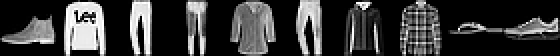

In [56]:
hcat([mnistview(xtst,i) for i=1:10]...)

In [57]:
ytst[1:10]'

1×10 LinearAlgebra.Adjoint{UInt8,Array{UInt8,1}}:
 0x0a  0x03  0x02  0x02  0x07  0x02  0x05  0x07  0x06  0x08

---

In [30]:
include("fashion-mnist/fashion-mnist.jl")

FashionMNIST.main("--epochs 15")

Main.FashionMNIST

In [51]:
include("../data/fashion-mnist.jl")

xtrn,ytrn,xtst,ytst = fmnist()
map(maximum,(xtrn,ytrn,xtst,ytst))

(1.0f0, 0x0a, 1.0f0, 0x0a)

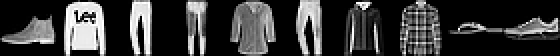

In [54]:
fmnistview(x,i) = Images.colorview(Gray,permutedims(x[:,:,1,i],(2,1)))
hcat([fmnistview(xtst,i) for i=1:10]...)

In [44]:
ytst[1:10]'

1×10 LinearAlgebra.Adjoint{UInt8,Array{UInt8,1}}:
 0x0a  0x03  0x02  0x02  0x07  0x02  0x05  0x07  0x06  0x08

---

In [65]:
FashionMNIST.main("--epochs 20 --hidden 32 32" )

fashion-mnist.jl (c) 2017 Adapted by Emre Unal based on Deniz Yuret’s MNIST example https://github.com/denizyuret/Knet.jl/tree/master/examples/mnist-mlp/mlp.jl.
Multi-layer perceptron model on the Fashion-MNIST dataset from https://github.com/zalandoresearch/fashion-mnist.

opts=(:batchsize, 100)(:fast, false)(:atype, "Array{Float32}")(:epochs, 20)(:gcheck, 0)(:winit, 0.1)(:dropout, 0.5)(:lr, 0.15)(:hidden, [32, 32])(:seed, -1)
(:epoch, 0, :trn, 0.10636666666666666, :tst, 0.1054)
(:epoch, 1, :trn, 0.8191166666666667, :tst, 0.8075)
(:epoch, 2, :trn, 0.84475, :tst, 0.8313)
(:epoch, 3, :trn, 0.8578, :tst, 0.8395)
(:epoch, 4, :trn, 0.8648333333333333, :tst, 0.8453)
(:epoch, 5, :trn, 0.8697833333333334, :tst, 0.8506)
(:epoch, 6, :trn, 0.8736333333333334, :tst, 0.8523)
(:epoch, 7, :trn, 0.8763333333333333, :tst, 0.8553)
(:epoch, 8, :trn, 0.8774166666666666, :tst, 0.8573)
(:epoch, 9, :trn, 0.8818, :tst, 0.8619)
(:epoch, 10, :trn, 0.8827166666666667, :tst, 0.8617)
(:epoch, 11, :trn, 0.88605, :

6-element Array{Any,1}:
 Float32[-0.0312892 0.0669809 … 0.160992 0.0619048; 0.192639 0.135134 … -0.0871503 0.00165933; … ; 0.0984376 -0.206092 … 0.0201828 -0.0537948; 0.122625 0.0826153 … -0.0891128 -0.071331]
 Float32[-0.0940021; 0.2726; … ; -0.135128; 0.62656]                                                                                                                                     
 Float32[0.20444 0.482465 … 0.0615954 -0.000367026; 0.759991 0.047565 … -0.137364 -0.209322; … ; -0.356647 0.0823732 … -0.721673 0.00137532; -0.0350939 -0.30446 … 0.257802 0.286187]    
 Float32[0.0487522; 0.474317; … ; 0.0818124; 0.400674]                                                                                                                                   
 Float32[0.377632 0.0417297 … 0.460254 -0.56439; 0.137855 0.165408 … -0.305564 -0.0494776; … ; 0.136445 -0.999339 … 0.416285 0.115632; -0.23831 0.0206515 … 0.53145 -0.173652]           
 Float32[-0.0384464; -0.162062; … ; 0.0447396;

In [63]:
FashionMNIST.main("--epochs 15 --hidden 64 32" )

fashion-mnist.jl (c) 2017 Adapted by Emre Unal based on Deniz Yuret’s MNIST example https://github.com/denizyuret/Knet.jl/tree/master/examples/mnist-mlp/mlp.jl.
Multi-layer perceptron model on the Fashion-MNIST dataset from https://github.com/zalandoresearch/fashion-mnist.

opts=(:batchsize, 100)(:fast, false)(:atype, "Array{Float32}")(:epochs, 15)(:gcheck, 0)(:winit, 0.1)(:dropout, 0.5)(:lr, 0.15)(:hidden, [64, 32])(:seed, -1)
(:epoch, 0, :trn, 0.07458333333333333, :tst, 0.0734)
(:epoch, 1, :trn, 0.8111, :tst, 0.8035)
(:epoch, 2, :trn, 0.8513833333333334, :tst, 0.8389)
(:epoch, 3, :trn, 0.8654666666666667, :tst, 0.8506)
(:epoch, 4, :trn, 0.8729166666666667, :tst, 0.8561)
(:epoch, 5, :trn, 0.8778833333333333, :tst, 0.86)
(:epoch, 6, :trn, 0.8824333333333333, :tst, 0.8654)
(:epoch, 7, :trn, 0.8864833333333333, :tst, 0.8681)
(:epoch, 8, :trn, 0.8893166666666666, :tst, 0.8697)
(:epoch, 9, :trn, 0.89165, :tst, 0.871)
(:epoch, 10, :trn, 0.8942166666666667, :tst, 0.8715)
(:epoch, 11, :trn, 0

6-element Array{Any,1}:
 Float32[0.183958 -0.0487741 … -0.104594 0.131875; -0.00313371 0.18052 … -0.0130205 0.0644176; … ; 0.0745418 0.0331381 … -0.0168326 -0.0455298; -0.00536668 -0.04791 … -0.024419 -0.0324855]
 Float32[0.349275; 0.391539; … ; 0.537315; -0.0412937]                                                                                                                                      
 Float32[0.137981 -0.153488 … -0.0959689 0.10526; 0.29923 0.23181 … -0.266603 0.0374204; … ; 0.0811019 0.181284 … -0.15439 0.137748; 0.184086 0.15751 … 0.0963871 0.0997669]                
 Float32[0.251531; 0.469832; … ; 0.025972; 0.22661]                                                                                                                                         
 Float32[-0.148285 -0.271458 … -0.52118 -0.213137; 0.00327551 0.824657 … -0.0209717 -0.111145; … ; -0.32125 -0.29331 … 0.170673 -0.149753; -0.414008 -0.53713 … 0.584343 0.179393]          
 Float32[0.118426; -0.239309; …